In [1]:
### Для запуска на colab

!pip install unidecode
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.7 MB/s eta 0:00:00
     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/433.8 kB 1.1 MB/s eta 0:00:01Collecting emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tqdm
import time

import re
import string
from unidecode import unidecode
import emoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchtext.vocab

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data loading

In [4]:
file_train = 'train_spam.csv'

data_train_all = pd.read_csv(file_train)

In [5]:
texts_train_all = data_train_all['text']
labels_all = data_train_all['text_type']
target_all = pd.Categorical(labels_all, categories=['ham', 'spam']).codes

## Preprocessing

Словарь строится на основе тренировочных дынных

In [6]:
lemmatizer = WordNetLemmatizer()

tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [7]:
def to_lower(words):
    result = words.lower()
    return result


def remove_underscore(words):
    return re.sub(r'_', ' ', words)

def remove_punctuation(words):
    result = re.sub(r'[!"#%&\'()*+,-./:;<=>?@\[\]^`{|}~]', ' ', words) # everything except underscore and $
    return result


def replace_hyperlink(words, replace=' <HTTP> '):
    return re.sub(r'http(?:\S*|\b)', replace, words)

def remove_hyperlink(words):
    return replace_hyperlink(words, '')


def emoji_to_text(words):
    return emoji.demojize(words)

def replace_emoji(words,  replace=' <EMOJI> '):
    return emoji.replace_emoji(words, replace=replace)

def remove_emoji(words):
    return replace_emoji(words, '')


def replace_non_ascii_words(words, replace=' <NONASCII> '):
    pattern = r'\b[^\x00-\x7F]+\b'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def replace_non_ascii(words, replace=' <NONASCII> '):
    pattern = r'[^\x00-\x7F]'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def remove_non_ascii(words):
    return unidecode(words)


def replace_number(words, replace=' <NUMBER> '):
    result = re.sub(r'\w*\d\w*', replace, words)
    return result

def remove_number(words):
    return replace_number(words, '')


def replace_currency(words, replace=' <CURRENCY> '):
    currency_pattern = r'[£$€₹]'
    return re.sub(currency_pattern, replace, words)

def remove_currency(words):
    return replace_currency(words, '')


def replace_tag(words, replace=' <TAG> '):
    return re.sub(r'\w*@\w*', replace, words)

def replace_exclamation(words, replace=' <EXCLAMATION> '):
    return re.sub(r'!', replace, words)

def replace_question(words, replace=' <QUESTION> '):
    return re.sub(r'\?', replace, words)

def replace_slash(words, replace=' <SLASH> '):
    return re.sub(r'/', replace, words)

def replace_colon(words, replace=' <COLON> '):
    return re.sub(r':', replace, words)


def remove_whitespace(words):
    return words.strip()

def replace_newline(words):
    return words.replace('\n', ' ')

def remove_stop_words(words):
    return [i for i in words if i not in ENGLISH_STOP_WORDS]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(s) for s in words]

In [8]:
def preprocess_pipeline(sentence, preprocess_utils=None):
    if preprocess_utils is None:
        preprocess_utils = [
            to_lower,
            replace_newline,
            remove_underscore,
            replace_hyperlink,
            replace_emoji,
            replace_non_ascii_words,
            replace_non_ascii,
            remove_non_ascii,
            remove_punctuation,
            remove_whitespace,
            tokenizer.tokenize,
            remove_stop_words,
            word_lemmatizer,
        ]
    for func in preprocess_utils:
        sentence = func(sentence)
    return sentence

In [12]:
preprocess_utils = [
    to_lower,
    replace_newline,
    replace_hyperlink,
    remove_underscore,
    replace_currency,
    replace_emoji,
    replace_non_ascii_words,
    replace_non_ascii,
    remove_non_ascii,
    replace_number,
    replace_tag,
    replace_exclamation,
    replace_question,
    replace_slash,
    replace_colon,
    remove_punctuation,
    remove_whitespace,
    tokenizer.tokenize,
    remove_stop_words,
    word_lemmatizer,
]


data_train_preprocess = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_train_all.to_numpy()
]

texts_train, texts_val, y_train, y_val = train_test_split(
                                        data_train_preprocess,
                                        target_all,
                                        shuffle=True,
                                        random_state=42,
                                        stratify=target_all)

### Строим словарь

In [13]:
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

Vocab = build_vocab(texts_train)

VOCAB_SIZE = len(Vocab)
PAD_IDX = Vocab['<PAD>']
SOS_IDX = Vocab['<SOS>']
EOS_IDX = Vocab['<EOS>']
UNK_IDX = Vocab['<UNK>']

In [14]:
print(VOCAB_SIZE)

11417


In [15]:
def generate_batch(data):
    features, target = [], []
    for text, y in data:
        features.append(torch.tensor([Vocab['<SOS>']] + \
                                  Vocab.lookup_indices(text) + \
                                  [Vocab['<EOS>']],
                                  dtype=torch.long))
        target.append(torch.tensor(y, dtype=torch.long))
    features = pad_sequence(features, padding_value=Vocab['<PAD>'], batch_first=True)
    target = torch.tensor(target)
    return features, target


BATCH_SIZE = 64

train_loader = DataLoader(list(zip(texts_train, y_train)), batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(list(zip(texts_val, y_val)), batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [16]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([64, 111])

## Model

In [17]:
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [18]:
class SpamWordRNN(nn.Module):
    def __init__(self, num_tokens, embed_size, hidden_size, drop_p=0.5):
        super(SpamWordRNN, self).__init__()

        self.num_tokens = num_tokens
        self.hidden_size = hidden_size
        self.emded_size = embed_size

        self.embedding = nn.Embedding(num_tokens, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dropout_embed = nn.Dropout(drop_p)
        self.dropout_rnn = nn.Dropout(drop_p)
        self.out = nn.Linear(hidden_size, 2)

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = self.dropout_embed(embedded)
        _, hidden = self.rnn(embedded)
        hidden = self.dropout_rnn(hidden[-1])
        output = self.out(hidden)
        return output


In [19]:
def train(model, optimizer, iterator, criterion, epoch, n_show = 50):
    model.train()

    train_loss_history = []
    train_loss = 0
    current_loss = 0
    for i, batch in tqdm.tqdm(enumerate(iterator), unit="batch", total=len(iterator)):
        optimizer.zero_grad()

        input, target = batch[0].to(DEVICE), batch[1].to(DEVICE)
        output = model(input)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_loss += current_loss
        train_loss_history.append(current_loss)

        # if i % n_show == 0:
        #     print(f'\n Epoch {epoch}, loss {current_loss:.3f}')

    return train_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input, target = batch[0].to(DEVICE), batch[1].to(DEVICE)

            output = model(input)

            loss = criterion(output, target)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


def calc_metrics(model, iterator):
    model.eval()

    y_true = []
    y_pred = []
    p_pred = []
    with torch.no_grad():
        for i, (input, target) in enumerate(iterator):
            y_true.extend(target.detach().cpu().tolist())
            input, target = input.to(DEVICE), target.to(DEVICE)

            output = model(input)

            prob_pred = F.softmax(output, dim=1)[:, 1].detach().cpu().tolist()
            target_pred = torch.argmax(output, dim=1).detach().cpu().tolist()
            p_pred.extend(prob_pred)
            y_pred.extend(target_pred)

    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, p_pred)
    )

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(m: torch.nn.Module, only_trainable: bool = True):
    """
    Returns the total number of parameters used by `m` (only counting
    shared parameters once); if `only_trainable` is True, then only
    includes parameters with `requires_grad = True`
    """
    parameters = list(m.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

def save_checkpoint(save_path,
                    model,
                    optimizer=None,
                    scheduler=None,
                    epoch=None,
                    train_history=None,
                    val_history=None,
                    roc_auc_val_history=None):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'train_history': train_history,
        'val_history': val_history,
        'roc_auc_val_history': roc_auc_val_history,
        'epoch': epoch
    }, save_path)

def load_checkpoint(load_path, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(load_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    train_history = checkpoint['train_history']
    val_history = checkpoint['val_history']
    roc_auc_val_history = checkpoint['roc_auc_val_history']
    epoch = checkpoint['epoch']

    return model, optimizer, epoch, train_history, val_history, roc_auc_val_history

In [52]:
new_start = True
checkpoint_path = 'checkpoint.pt'

EMB_SIZE = 256
HID_SIZE = 256
DROPOUT = 0.5

learning_rate = 0.002
lr_decay = 0.90

In [53]:
best_val_loss = float('inf')

train_history = []
val_history = []

epoch = 0
epoch_history = []

accuracy_val = 0
precision_val = 0
recall_val = 0
f1_val = 0
roc_auc_val = 0
roc_auc_val_history = []

model = SpamWordRNN(VOCAB_SIZE, EMB_SIZE, HID_SIZE, DROPOUT).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = ExponentialLR(optimizer, gamma=lr_decay)

if not new_start:
    model, optimizer, epoch, mean_rw_history, td_loss_history, initial_state_v_history = \
                                   load_checkpoint(checkpoint_path, model, optimizer)
    print(f'Resuming from epoch {epoch}')

print(f'Number of parameters: {count_parameters(model)}')

Number of parameters: 3318018


In [54]:
N_epochs = 8
n_show = 100

Epoch: 09 | Time: 0m 3s
Train loss: 0.048; Val. loss: 0.143
Accuracy 0.9639, Precision 0.9559, Recall 0.9201, f1 0.9377, ROC AUC 0.9900


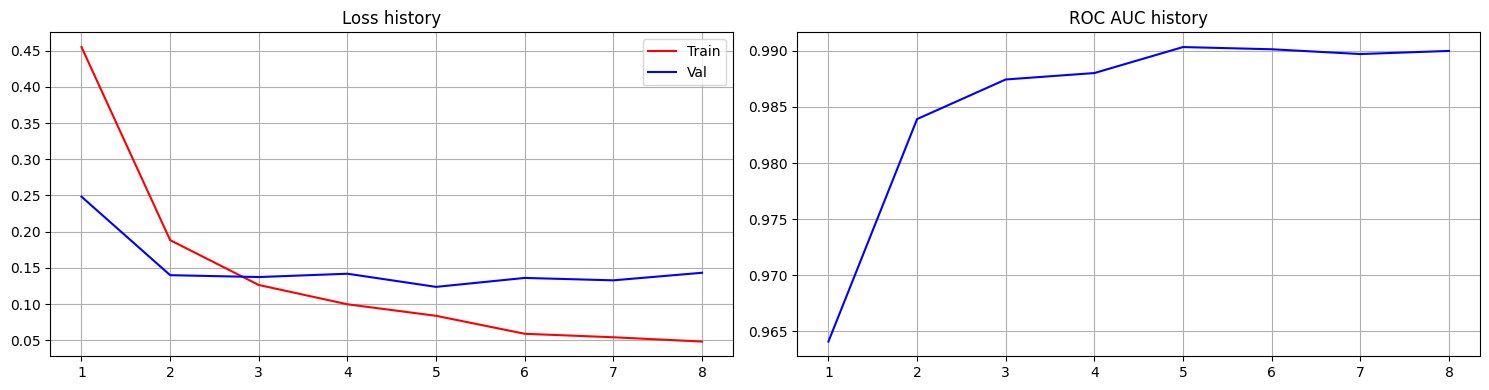

In [55]:
for epoch in range(epoch + 1, N_epochs+1):
    start_time = time.time()

    train_loss = train(model,
                       optimizer,
                       train_loader,
                       criterion,
                       epoch,
                       n_show)
    lr_scheduler.step()

    val_loss = evaluate(model, val_loader, criterion)

    (accuracy_val,
    precision_val,
    recall_val,
    f1_val,
    roc_auc_val) = calc_metrics(model, val_loader)
    roc_auc_val_history.append(roc_auc_val)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_val_loss and val_loss < 0.16:
        best_val_loss = val_loss
        save_checkpoint(checkpoint_path, model, optimizer, lr_scheduler,
                        epoch, train_history, val_history, roc_auc_val_history)

    train_history.append(train_loss)
    val_history.append(val_loss)
    epoch_history.append(epoch)

    clear_output(True)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train loss: {train_loss:.3f}; Val. loss: {val_loss:.3f}')
    print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
    print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.4f}')

    plt.figure(figsize=[15, 4])

    plt.subplot(1, 2, 1)
    plt.title("Loss history")
    plt.plot(epoch_history, train_history, color='r', label='Train')
    plt.plot(epoch_history, val_history, color='b', label='Val')
    plt.legend()
    # plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("ROC AUC history")
    plt.plot(epoch_history, roc_auc_val_history, color='b')
    plt.grid()

    plt.tight_layout()
    plt.show()


In [56]:
# save_checkpoint(checkpoint_path, model, optimizer, lr_scheduler,
#                 epoch, train_history, val_history, roc_auc_val_history)

### Validation scores

In [57]:
(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(model, val_loader)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.4f}')

Accuracy 0.9634, Precision 0.9551, Recall 0.9193, f1 0.9368, ROC AUC 0.9900


### Plot ROC curve

In [58]:
y_true = []
y_pred = []
p_pred = []
with torch.no_grad():
    for i, (input, target) in tqdm.tqdm(enumerate(val_loader)):
        y_true.extend(target.detach().cpu().tolist())
        input, target = input.to(DEVICE), target.to(DEVICE)

        output = model(input)

        prob_pred = F.softmax(output, dim=1)[:, 1].detach().cpu().tolist()
        target_pred = torch.argmax(output, dim=1).detach().cpu().tolist()
        p_pred.extend(prob_pred)
        y_pred.extend(target_pred)

fpr, tpr, threshold = roc_curve(y_true, p_pred)
roc_auc = auc(fpr, tpr)

64it [00:00, 125.17it/s]


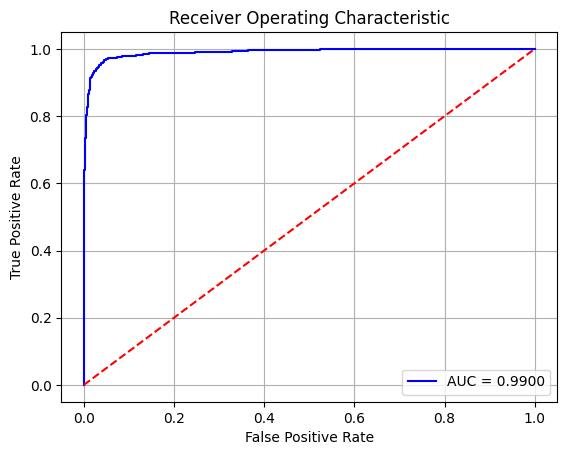

In [59]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

## Predict labels for test data

In [63]:
file_test = 'test_spam.csv'

data_test = pd.read_csv(file_test)

texts_test = data_test['text']

In [64]:
data_test_preprocess = [
    preprocess_pipeline(sent) for sent in texts_test.to_numpy()
]

In [65]:
def generate_test_batch(data):
    features = []
    for text in data:
        features.append(torch.tensor([Vocab['<SOS>']] + \
                                  Vocab.lookup_indices(text) + \
                                  [Vocab['<EOS>']],
                                  dtype=torch.long))
    features = pad_sequence(features, padding_value=Vocab['<PAD>'], batch_first=True)
    return features


test_loader = DataLoader(data_test_preprocess, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_test_batch)

In [66]:
def predict_proba(model, iterator):
    model.eval()

    p_pred = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input = batch.to(DEVICE)

            output = model(input)

            prob_pred = F.softmax(output, dim=1)[:, 1].detach().cpu().tolist()
            p_pred.extend(prob_pred)
    return p_pred

pred_prob = predict_proba(model, test_loader)

In [67]:
data_test.insert(0, 'score', pred_prob)

data_test.to_csv('test_spam_scored.csv')

data_test.head()

,score,text
0,0.000434,j jim whitehead ejw cse ucsc edu writes j you ...
1,0.000407,original message from bitbitch magnesium net p...
2,0.000288,java for managers vince durasoft who just taug...
3,0.000737,there is a youtuber name saiman says
4,0.996754,underpriced issue with high return on equity t...
